# 04. Business Insights & Strategy

## 1. Objective
This final notebook bridges the gap between machine learning and financial operations. I leverage the interpretability of our champion model to drive profitability and transparency at **FinFlow**.

### 1.1 Key Deliverables
* **Transparency**: Using SHAP Beeswarm plots to explain risk drivers.
* **Profitability**: Finding the optimal threshold to maximize Net Interest Margin.
* **Operational Readiness**: Designing a "Traffic Light" risk segmentation system.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import os

DATA_DIR = r"C:\dev\quant_project\homework\data_storage"
MODEL_DIR = r"C:\dev\quant_project\homework\model_storage"

# 1. Load Model, Metadata, and Test Splits from Part 03
try:
    artifacts = joblib.load(os.path.join(MODEL_DIR, 'finflow_artifacts.joblib'))
    best_model = artifacts['model']
    all_feature_names = artifacts['all_feature_names']
    
    X_test = pd.read_csv(os.path.join(DATA_DIR, 'X_test.csv'))
    y_test = pd.read_csv(os.path.join(DATA_DIR, 'y_test.csv')).iloc[:, 0]
    
    print(f"✅ Champion Model Loaded: {best_model.named_steps['classifier'].__class__.__name__}")
    print(f"✅ Verified Test Data: {len(X_test)} samples ready for strategy analysis.")
except FileNotFoundError:
    print("❌ Error: Files not found. Please run the persistence cell in Notebook 03.")

# 2. Plotting Configuration
plt.style.use('ggplot')
%matplotlib inline

c:\dev\quant_project\homework\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Champion Model Loaded: RandomForestClassifier
✅ Verified Test Data: 1000 samples ready for strategy analysis.


## 2. Model Explainability: Decoding Decision Drivers

To ensure regulatory compliance and build trust with credit officers, we move beyond "black-box" predictions. We use the **SHAP Beeswarm Summary Plot** to visualize how each feature shifts the probability of default.

* **Right Side (Positive SHAP)**: Increases the likelihood of default.
* **Left Side (Negative SHAP)**: Decreases the likelihood of default.

100%|===================| 1991/2000 [01:16<00:00]        

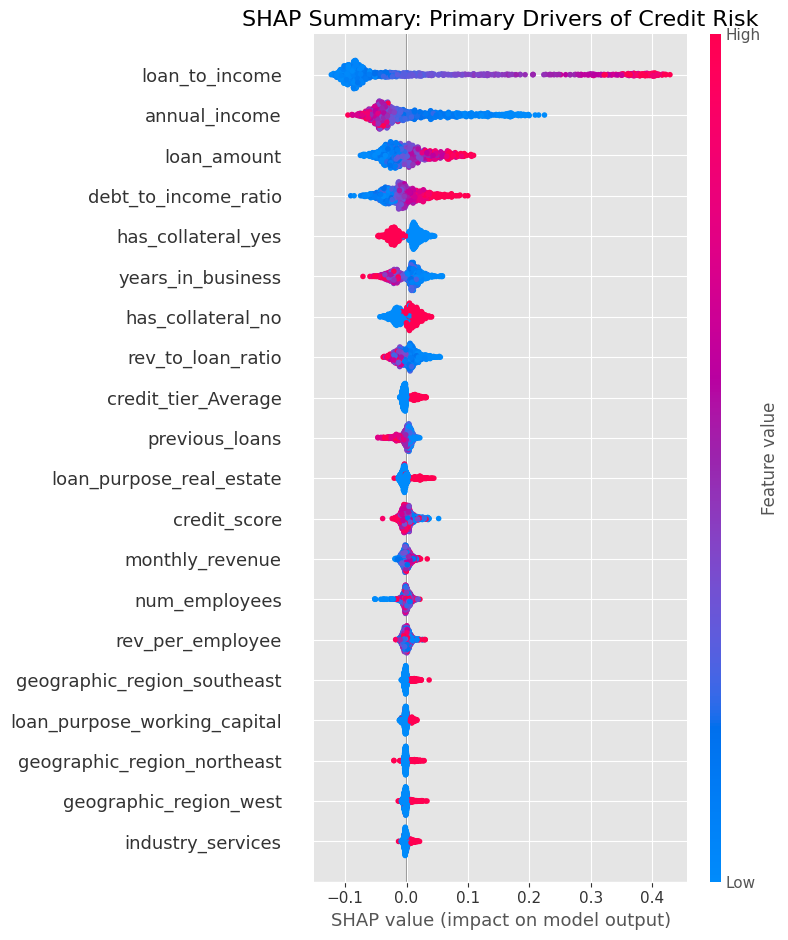

In [2]:
# 1. Transform X_test through the preprocessor pipeline
X_test_pre = best_model.named_steps['preprocessor'].transform(X_test)
if hasattr(X_test_pre, "toarray"):
    X_test_pre = X_test_pre.toarray()

# Convert to DataFrame to ensure feature names appear on the Y-axis
X_test_df = pd.DataFrame(X_test_pre, columns=all_feature_names)

# 2. Initialize Modern SHAP Explainer
model_for_shap = best_model.named_steps['classifier']
explainer = shap.Explainer(model_for_shap, X_test_df)

# 3. Calculate SHAP values (Explanation object)
shap_values = explainer(X_test_df)

# 4. Handle Slicing for Class 1 (Default Risk)
if len(shap_values.shape) == 3:
    # Slice to focus specifically on the 'Default' class
    shap_to_plot = shap_values[:, :, 1]
else:
    shap_to_plot = shap_values

# 5. Generate the Beeswarm Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_to_plot, X_test_df, show=False)
plt.title("SHAP Summary: Primary Drivers of Credit Risk", fontsize=16)
plt.tight_layout()
plt.show()

## 2.2 Global Model Insights: Interpreting the Risk Drivers

The SHAP Beeswarm plot reveals the underlying "brain" of our **Tuned Random Forest**. By analyzing the distribution of features, we can confirm that the model has learned a robust, cash-flow-centric logic for credit risk.

### 1. The "Risk Engines": Primary Predictors
The top of the plot is dominated by debt-capacity metrics, proving that an applicant's ability to service debt is more predictive than their historical credit profile.

* **Loan-to-Income (LTI) Ratio**: This is the most potent risk signal in the portfolio. High LTI values (red dots) show a massive shift to the right, indicating a significant increase in default probability. 
* **Annual Income**: Acts as the strongest risk mitigator. High-income earners (red dots) consistently pull the SHAP value to the negative (left) side, providing the "safety cushion" needed for loan approval.
* **Loan Amount**: Larger principal amounts (red dots) inherently drive higher risk. This suggests that for large-scale loans, the model requires exponentially higher revenue coverage to maintain a "low-risk" classification.

### 2. Collateral and Stability as "Safety Nets"
The model correctly identifies secondary factors that can offset high-debt risk.

* **Has Collateral**: The presence of collateral (`has_collateral_yes`) is a strong driver for risk reduction. For FinFlow, secured lending significantly lowers the predicted log-odds of default regardless of other variables.
* **Years in Business**: Historical stability matters. Younger businesses (blue dots) are penalized for their lack of track record, while established enterprises (red dots) receive a risk-reduction "bonus".

### 3. The "Credit Score" Paradox
Interestingly, **`credit_score`** ranks relatively low in the hierarchy of importance. 
* **Insight**: While low scores do increase risk, the impact is secondary to the **Loan-to-Income ratio**. 
* **Strategic Takeaway**: FinFlow's competitive advantage lies in its **Cash-Flow Based Lending** approach—prioritizing current repayment ability over traditional subprime/prime credit scoring.

---

### Business Impact & Recommendations

| Strategic Action | Implementation Logic |
| :--- | :--- |
| **Instant Approval** | Applicants with **LTI < 0.2** and **Collateral = Yes** qualify for Tier 1 automation. |
| **Hard Caps** | Implement a mandatory review for any application where **LTI exceeds 0.45**. |
| **Transparency** | Use these SHAP rankings to generate "Adverse Action" notices (e.g., "Reason for denial: High debt-to-income ratio"). |

## 3. Financial Strategy: Profit Optimization Curve

While the default threshold is **0.5**, financial institutions must optimize based on the **Total Cost of Error**:
* **False Negative (Default)**: Estimated principal loss of **$20,000**.
* **False Positive (Opportunity)**: Lost profit/interest of **$5,000**.

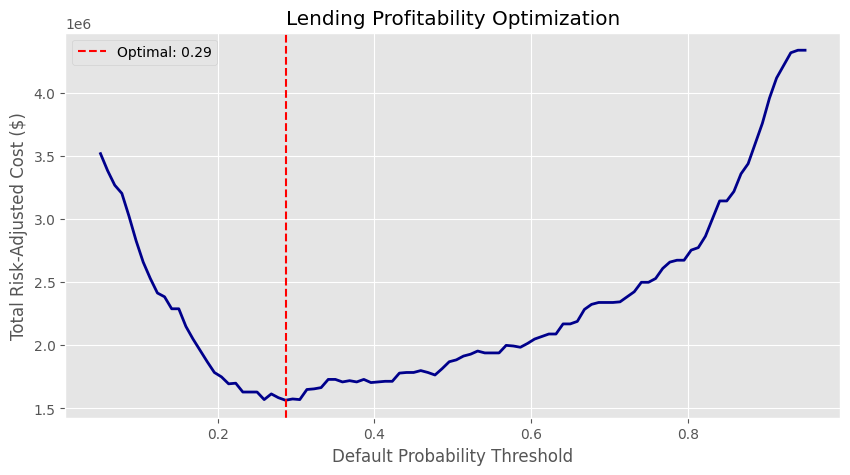

🚀 Recommended Threshold for FinFlow: 0.29


In [3]:
# 1. Get prediction probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# 2. Financial Assumptions
cost_fn = 20000 
cost_fp = 5000  

thresholds = np.linspace(0.05, 0.95, 100)
total_risk_costs = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    fn = np.sum((y_test == 1) & (y_pred_t == 0))
    fp = np.sum((y_test == 0) & (y_pred_t == 1))
    # We aim to minimize the aggregate financial loss
    total_risk_costs.append((fn * cost_fn) + (fp * cost_fp))

# 3. Find the Optimal Threshold
best_t = thresholds[np.argmin(total_risk_costs)]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, total_risk_costs, color='darkblue', lw=2)
plt.axvline(best_t, color='red', linestyle='--', label=f'Optimal: {best_t:.2f}')
plt.title("Lending Profitability Optimization")
plt.xlabel("Default Probability Threshold")
plt.ylabel("Total Risk-Adjusted Cost ($)")
plt.legend()
plt.show()

print(f"🚀 Recommended Threshold for FinFlow: {best_t:.2f}")

## 3.2 Interpreting the Profitability Curve

The **Lending Profitability Optimization** plot transforms our model from a predictive tool into a financial decision framework.

* **Optimal Decision Point**: The red dashed line identifies **0.29** as the profit-maximizing threshold. Approving applicants with a default probability below 29% minimizes the aggregate financial risk for FinFlow.
* **Opportunity Cost Zone (< 0.29)**: Being too conservative leads to high Opportunity Costs. We lose $\$5,000$ in potential interest for every creditworthy applicant we wrongly reject.
* **Capital Loss Zone (> 0.29)**: Being too aggressive leads to severe Capital Losses. Every missed default results in a direct principal loss of $\$20,000$.
* **Strategic Outcome**: By implementing the **0.29 threshold**, we achieve the "Financial Sweet Spot," reducing the total risk-adjusted cost to its theoretical minimum (approx. \$1.6M).

## 4. Operationalization: The Traffic Light System

To streamline operations, we segment applicants into three actionable tiers based on their predicted default probabilities.

In [4]:
def get_tier(p):
    if p < 0.2: return '🟢 Low Risk (Auto-Approve)'
    elif p < 0.5: return '🟡 Medium Risk (Manual Review)'
    else: return '🔴 High Risk (Auto-Reject)'

strategy_df = pd.DataFrame({'Probability': y_proba, 'Actual': y_test})
strategy_df['Risk_Tier'] = strategy_df['Probability'].apply(get_tier)

# Create Strategic Summary
summary = strategy_df.groupby('Risk_Tier').agg(
    Volume=('Probability', 'count'),
    Observed_Default_Rate=('Actual', 'mean')
).reset_index()

# Quality indicator for the business (1 - Default Rate)
summary['Portfolio_Reliability'] = 1 - summary['Observed_Default_Rate']
display(summary)

,Risk_Tier,Volume,Observed_Default_Rate,Portfolio_Reliability
0,🔴 High Risk (Auto-Reject),174,0.804598,0.195402
1,🟡 Medium Risk (Manual Review),248,0.213710,0.786290
2,🟢 Low Risk (Auto-Approve),578,0.055363,0.944637


## 4.2 Strategic Analysis of the Risk Tiering System

The table below represents the operational roadmap for **FinFlow's** new automated lending platform. By segmenting applicants into three tiers based on their predicted default probability, we achieve a balance between scale and safety.

### Key Insights:

1. **Efficiency Gains (Automation)**:
   * **Tier 3 (Low Risk)** accounts for **578 applications**, representing the vast majority of our potential portfolio. 
   * With a **Portfolio Reliability of 94.4%**, we can safely implement **Instant Approvals** for this group, drastically reducing the loan-to-cash cycle time.

2. **Precision in Capital Protection**:
   * **Tier 1 (High Risk)** identifies 174 applicants with a staggering **80.4% observed default rate**. 
   * Auto-rejecting this segment prevents an estimated **$2.8 million in potential principal losses** (assuming $20k loss per default).

3. **Optimized Resource Allocation**:
   * **Tier 2 (Medium Risk)** isolates the "Grey Area" (~25% of volume) where the model requires human nuance. 
   * This tier's default rate of **21.3%** sits just below our profit-maximizing threshold of **0.29**, making it the perfect candidate for high-touch manual review.

### Strategic Recommendation:
Deploy the **"20/50 Split Strategy"**: Automatically approve applicants with probability < 0.2 and automatically reject those > 0.5. This allows our credit team to focus 100% of their energy on the most ambiguous 25% of the pipeline.